In [1]:
!nvidia-smi

Tue Jul  9 09:53:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   36C    P0              17W /  80W |      9MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Imports

In [2]:
import torch 
import torch.nn.functional as F

import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))

32033


# Setup Data

In [4]:
# List of characters present in dataset
chars = sorted(list(set(''.join(words))))

# mapping characters to indices
c2i = {c: i+1 for i, c in enumerate(chars)}
c2i['.'] = 0

# inverse mapping
i2c = {i: c for c, i in c2i.items()}
vocab_size = len(i2c)
print(i2c)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
random.seed(42)
random.shuffle(words)

In [6]:
block_size = 8

def build_dataset(words):
    x, y = [], []
    for word in words:
        # context vector to predict next word
        context = [0] * block_size
        for char in word + '.':
            # index of character to predict 
            idx = c2i[char]
            x.append(context)
            y.append(idx)
            
            # updating context vector
            context = context[1:] + [idx]
            
    x, y = torch.tensor(x), torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

# create train val test dataset splits
train_split = int(0.8 * len(words))
test_split = int(0.9 * len(words))
x_train, y_train = build_dataset(words[:train_split])
x_val, y_val = build_dataset(words[train_split: test_split])
x_test, y_test = build_dataset(words[test_split:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x, y in zip(x_train[:14], y_train[:14]):
    print(''.join(i2c[idx.item()] for idx in x), '==>', i2c[y.item()])

........ ==> y
.......y ==> u
......yu ==> h
.....yuh ==> e
....yuhe ==> n
...yuhen ==> g
..yuheng ==> .
........ ==> d
.......d ==> i
......di ==> o
.....dio ==> n
....dion ==> d
...diond ==> r
..diondr ==> e


# ***torch.nn*** Layers 

### 1. Linear Layer 
$$z \ = \ X.W^T \ + \ b$$

In [53]:
class Linear:
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        self.weight = torch.randn((in_features, out_features)) / in_features ** 0.5 
        self.bias = torch.zeros(out_features) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [54]:
Linear(3, 3).parameters()

[tensor([[ 0.8489,  0.4531,  0.9633],
         [ 0.2164, -1.0741, -0.3948],
         [ 0.0142, -0.3412,  0.6973]]),
 tensor([0., 0., 0.])]

### 2. BatchNorm1d 
$$ y  \ = \ \frac{x \ - \ E[x]}{\sqrt{Var[x]} \ + \ \epsilon}*\gamma \ + \ \beta $$

In [10]:
class BatchNorm1d:
    def __init__(self, num_features: int, eps: float = 1e-05, momentum: float = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters 
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        
        # buffers
        self.moving_mean = torch.zeros(num_features)
        self.moving_var = torch.ones(num_features)
        
    def __call__(self, x):
        if self.training:
            # while training calculate the current batch mean and variance
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            x_mean = x.mean(dim, keepdim = True)
            x_var = x.var(dim, keepdim = True)
        else:
            # while testing use the pre-computed values for mean and variance
            x_mean = self.moving_mean
            x_var = self.moving_var
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta
        
        # update buffers
        if self.training:
            with torch.no_grad():
                self.moving_mean = (1 - self.momentum) * self.moving_mean + self.momentum * x_mean
                self.moving_var = (1 - self.momentum) * self.moving_var + self.momentum * x_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [11]:
BatchNorm1d(3, eps=1e-05, momentum=0.1).parameters()

[tensor([1., 1., 1.]), tensor([0., 0., 0.])]

### 3. Embedding

In [12]:
class Embedding:
    def __init__(self, num_embeddings: int, embedding_dim: int):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, idx):
        return self.weight[idx]
    
    def parameters(self):
        return [self.weight]

In [13]:
Embedding(5, 5).parameters()

[tensor([[-0.2764,  0.6572,  0.3120, -1.9155,  0.2057],
         [ 0.4045, -0.1234,  0.2120,  0.0409, -0.4678],
         [-0.2231, -0.3746,  1.9151,  0.5199,  1.6371],
         [-0.3742, -0.7303,  0.4207, -0.0730,  1.4254],
         [-0.9124, -1.0131,  0.3700,  0.1357,  0.6166]])]

### 4. Flatten 

In [14]:
class nFlatten:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        return x
    
    @staticmethod
    def parameters():
        return []

### 5. Sequential Container

In [15]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [16]:
Sequential([Linear(4,4), nFlatten(4), Linear(2,2)]).parameters()

[tensor([[-0.9851, -0.5391,  0.5067,  0.0242],
         [ 0.1223,  0.7353,  0.0937, -0.0806],
         [ 0.1913, -0.3374,  0.0307, -0.0576],
         [-0.4139, -0.1793,  1.0350,  0.3809]]),
 tensor([0., 0., 0., 0.]),
 tensor([[ 0.1683, -1.0861],
         [ 0.6111,  0.1342]]),
 tensor([0., 0.])]

# Model Architecture

In [17]:
torch.manual_seed(42);

In [18]:
class Tanh:
    def __call__(self, x):
        return torch.tanh(x)
    
    @staticmethod
    def parameters():
        return []

In [19]:
n_embedding = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embedding),
    nFlatten(2), Linear(n_embedding * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden), Tanh(),
    nFlatten(2), Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden), Tanh(),
    nFlatten(2), Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


# Model Training

In [20]:
max_steps = 200000
batch_size = 32
lossi = []

In [21]:
def train(model, max_steps, lossi):
    for i in range(max_steps):
        # get data minibatch
        idx = torch.randint(0, x_train.shape[0], (batch_size, ))
        x_batch, y_batch = x_train[idx], y_train[idx]
    
        # forward pass
        logits = model(x_batch)
        loss = F.cross_entropy(logits, y_batch)
    
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # parameter update
        lr = 0.1 if i < 150000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad
        
        # print stats
        if i % 10000 == 0:
            print(f'[{i:7d} / {max_steps:7d}] : {loss.item():.4f}')
        lossi.append(loss.log10().item())


In [22]:
train(model, max_steps, lossi)

[      0 /  200000] : 3.3167
[  10000 /  200000] : 2.0576
[  20000 /  200000] : 2.0723
[  30000 /  200000] : 2.5134
[  40000 /  200000] : 2.1476
[  50000 /  200000] : 1.7836
[  60000 /  200000] : 2.2592
[  70000 /  200000] : 1.9331
[  80000 /  200000] : 1.6875
[  90000 /  200000] : 2.0395
[ 100000 /  200000] : 1.7736
[ 110000 /  200000] : 1.9569
[ 120000 /  200000] : 1.7465
[ 130000 /  200000] : 1.8126
[ 140000 /  200000] : 1.7406
[ 150000 /  200000] : 1.7466
[ 160000 /  200000] : 1.8806
[ 170000 /  200000] : 1.6266
[ 180000 /  200000] : 1.6476
[ 190000 /  200000] : 1.8555


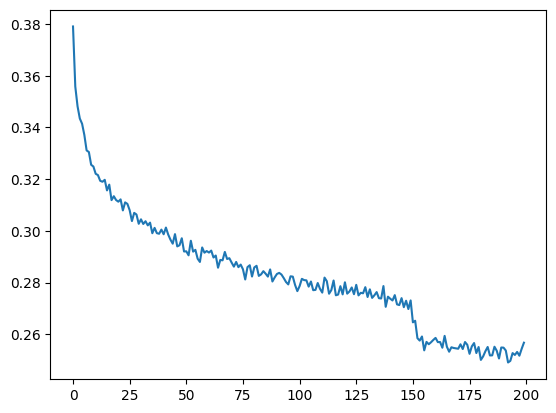

In [23]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

# Metrics

In [24]:
for layer in model.layers:
    layer.training = False

In [25]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' : (x_train, y_train),
        'val' : (x_val, y_val),
        'test' : (x_test, y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.7690280675888062
val 1.993653416633606


# Inference

In [26]:
for _ in range(25):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)
        
        idx = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [idx]
        out.append(idx)
        
        if idx == 0:
            break
    print(''.join(i2c[idx] for idx in out))
        

aiyanah.
giusopf.
lorron.
roger.
rhyitte.
christell.
jedmccee.
kelipson.
briyah.
sylot.
zennica.
mythan.
daxphon.
petrit.
adalie.
jeniyah.
glatipe.
manaswi.
yeslee.
stephania.
kharson.
anabella.
harlee.
mangels.
leamir.
